In [1]:
# Simulation parameters
n_sub = 1024 # number of subjects
n_time = 1024 # number of timepoints per subject

In [2]:
import seaborn as sns
import imageio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import nibabel as nib
import random
import pickle
from pathlib import Path

In [3]:
pconn_path = "/projects/standard/feczk001/shared/projects/ABCD/gordon_sets/data/group2_10minonly_FD0p1/sub-NDARINV00J52GPG_ses-baselineYear1Arm1_task-rest_bold_roi-Gordon2014FreeSurferSubcortical_timeseries.ptseries.nii_5_minutes_of_data_at_FD_0.2.pconn.nii"

In [4]:
pconn_dir = "/projects/standard/feczk001/shared/projects/ABCD/gordon_sets/data/group2_10minonly_FD0p1"

pconn_files = [
    os.path.join(pconn_dir, f)
    for f in os.listdir(pconn_dir)
    if f.endswith(".pconn.nii")
]

random_pconn = random.choice(pconn_files)
print("Randomly selected:", random_pconn)

conn = np.squeeze(nib.load(random_pconn).get_fdata())
print("Shape:", conn.shape)

Randomly selected: /projects/standard/feczk001/shared/projects/ABCD/gordon_sets/data/group2_10minonly_FD0p1/sub-NDARINVTA165FA9_ses-baselineYear1Arm1_task-rest_bold_roi-Gordon2014FreeSurferSubcortical_timeseries.ptseries.nii_all_frames_at_FD_0.1.pconn.nii
Shape: (352, 352)


In [5]:
img = nib.load(random_pconn)
conn = np.squeeze(img.get_fdata())

print("Connectivity shape:", conn.shape)

Connectivity shape: (352, 352)


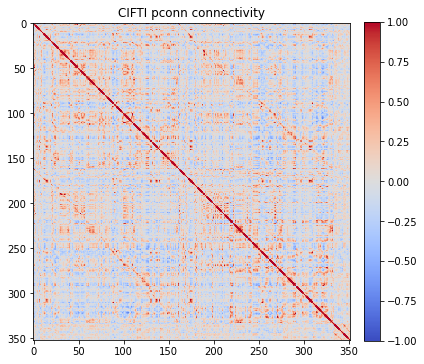

In [6]:
plt.figure(figsize=(6, 6))
im = plt.imshow(conn, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("CIFTI pconn connectivity")
plt.tight_layout()
plt.show()


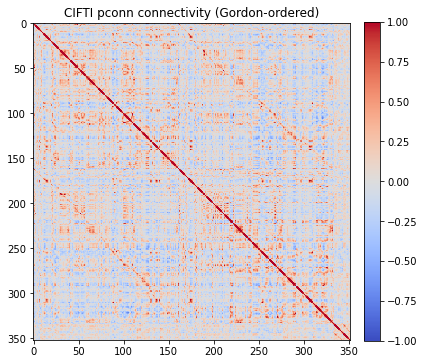

In [7]:
order_df = pd.read_csv("/scratch.global/and02709/second_python/Gordon_network_order.csv")

# --- helper: find a numeric index column, if it exists ---
def pick_numeric_index_column(df):
    # try common names first
    preferred = ["index", "idx", "node", "roi", "parcel_index", "parcelidx", "cifti_index"]
    for c in df.columns:
        if c.lower() in preferred:
            s = pd.to_numeric(df[c], errors="coerce")
            if s.notna().all():
                return c

    # otherwise, search for ANY fully-numeric column that looks like indices
    for c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().all():
            return c

    return None

col = pick_numeric_index_column(order_df)

if col is None:
    # No numeric index column -> assume row order defines Gordon ordering
    order = np.arange(len(order_df), dtype=int)
else:
    order = pd.to_numeric(order_df[col], errors="raise").to_numpy(dtype=int)

    # auto-convert 1-based -> 0-based if it matches N
    if order.min() == 1 and order.max() == conn.shape[0]:
        order = order - 1

# --- sanity checks ---
n = conn.shape[0]
assert conn.shape == (n, n), "conn must be square"
assert len(order) == n, f"Order length ({len(order)}) must match conn size ({n})"
assert set(order.tolist()) == set(range(n)), "Order is not a valid permutation of 0..N-1"

# --- reorder + plot (same style you want) ---
conn_ordered = conn[np.ix_(order, order)]

plt.figure(figsize=(6, 6))
im = plt.imshow(conn_ordered, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("CIFTI pconn connectivity (Gordon-ordered)")
plt.tight_layout()
plt.show()

ndim : 1
shape: (61776,)
dtype: float64
min/max: -2.6612044293978223 4.443005069745376
Inferred N: 352


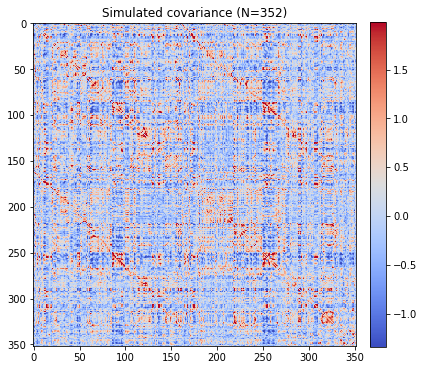

In [8]:
npy_path = "/scratch.global/and02709/second_python/pwr_data/dat_size_2000_index_1400_cov.npy"

# ---- Load FIRST ----
mat = np.load(npy_path)

# ---- Inspect ----
print("ndim :", mat.ndim)
print("shape:", mat.shape)
print("dtype:", mat.dtype)
print("min/max:", mat.min(), mat.max())

# ---- Expect a vectorized upper triangle ----
assert mat.ndim == 1, "Expected a 1D upper-triangle vector"

vec = mat
L = vec.shape[0]

# Infer matrix dimension N from L = N*(N-1)/2
N = int((1 + np.sqrt(1 + 8 * L)) / 2)
assert N * (N - 1) // 2 == L, "Vector length is not a valid upper-triangle size"

print("Inferred N:", N)   # should be 352

# ---- Reconstruct full symmetric matrix ----
full = np.zeros((N, N), dtype=vec.dtype)
iu = np.triu_indices(N, k=1)
full[iu] = vec
full = full + full.T

# Optional diagonal handling (choose ONE if desired)
# np.fill_diagonal(full, 0.0)   # covariance-style
# np.fill_diagonal(full, 1.0)   # correlation-style visualization

# ---- Plot ----
plt.figure(figsize=(6, 6))
im = plt.imshow(
    full,
    cmap="coolwarm",
    vmin=np.percentile(full, 2),
    vmax=np.percentile(full, 98),
)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title(f"Simulated covariance (N={N})")
plt.tight_layout()
plt.show()


ndim: 1
shape: (61776,)
dtype: float64
Inferred N: 352


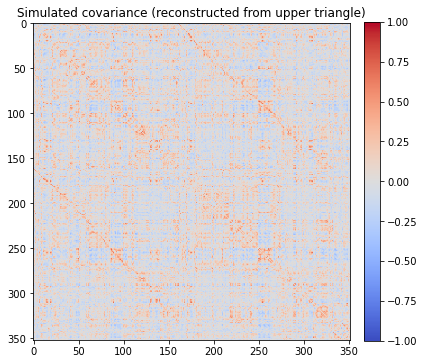

In [9]:
npy_path = "/scratch.global/and02709/second_python/pwr_data/dat_size_2000_index_1470_cor.npy"

print("ndim:", mat.ndim)
print("shape:", mat.shape)
print("dtype:", mat.dtype)

mat = np.load(npy_path)

vec = mat  # your loaded (61776,) vector

L = vec.shape[0]
N = int((1 + np.sqrt(1 + 8*L)) / 2)
assert N * (N - 1) // 2 == L, "Vector length is not a valid upper-triangle size"

print("Inferred N:", N)  # should print 352

# Fill upper triangle (k=1) then mirror to lower triangle
full = np.zeros((N, N), dtype=vec.dtype)
iu = np.triu_indices(N, k=1)
full[iu] = vec
full = full + full.T

# If you *know* this is a covariance, diagonal is not in vec, so leave it at 0 unless you have it elsewhere.
# If you want something on the diagonal for visualization, uncomment ONE of these:
# np.fill_diagonal(full, 0.0)   # neutral for cov
# np.fill_diagonal(full, 1.0)   # if you want correlation-like display

plt.figure(figsize=(6, 6))
im = plt.imshow(full, vmin=-1, vmax=1, cmap="coolwarm")  # don't clamp to [-1, 1] for covariance
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Simulated covariance (reconstructed from upper triangle)")
plt.tight_layout()
plt.show()

In [10]:
# Reading the metrics data
with open('metrics_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Reading the metrics summary
with open('metrics_summary.pkl', 'rb') as file:
    summary = pickle.load(file)

print(summary)

     size  mean_metric  sd_metric
0   100.0     0.373698   0.018502
1   139.0     0.397265   0.009330
2   194.0     0.424777   0.007128
3   271.0     0.434931   0.009930
4   378.0     0.444470   0.005342
5   528.0     0.461736   0.006471
6   736.0     0.472732   0.005074
7  1027.0     0.485816   0.001848
8  1433.0     0.499898   0.003331
9  2000.0     0.512961   0.001643


In [11]:
from pathlib import Path
import numpy as np

WRKDIR = Path("/scratch.global/and02709/second_python")
pwr_dir = WRKDIR / "pwr_data"
files = sorted(p for p in pwr_dir.iterdir() if p.name.endswith("_cvr2.npy"))

print("n files:", len(files))
for p in files[:10]:
    a = np.load(p, allow_pickle=True)
    arr = np.asarray(a)
    print(p.name, "dtype=", arr.dtype, "shape=", arr.shape, "first=", arr.reshape(-1)[0])


n files: 50
data_100_fold_1_cvr2.npy dtype= float64 shape= () first= 0.36899549624227107
data_100_fold_2_cvr2.npy dtype= float64 shape= () first= 0.39936844417823886
data_100_fold_3_cvr2.npy dtype= float64 shape= () first= 0.37417182220131195
data_100_fold_4_cvr2.npy dtype= float64 shape= () first= 0.3781115144904475
data_100_fold_5_cvr2.npy dtype= float64 shape= () first= 0.34784122347170765
data_1027_fold_1_cvr2.npy dtype= float64 shape= () first= 0.485838920683633
data_1027_fold_2_cvr2.npy dtype= float64 shape= () first= 0.4888039110752326
data_1027_fold_3_cvr2.npy dtype= float64 shape= () first= 0.4850586775611326
data_1027_fold_4_cvr2.npy dtype= float64 shape= () first= 0.4855904506008072
data_1027_fold_5_cvr2.npy dtype= float64 shape= () first= 0.4837877280645288


In [12]:
pwr_dir = Path("/scratch.global/and02709/second_python/pwr_data")
splits = sorted(pwr_dir.glob("full_*_fold_*_split.npz"))
print("n_splits:", len(splits))

def summarize_npz(npz_path, max_cols=10):
    z = np.load(npz_path, allow_pickle=True)
    print("\n===", npz_path.name, "===")
    print("keys:", list(z.keys()))
    for k in z.keys():
        a = np.asarray(z[k])
        print(f"  {k:12s} shape={a.shape} dtype={a.dtype} finite_frac={np.isfinite(a).mean() if a.size else 'NA'}")
        if a.size and a.dtype != object:
            flat = a.reshape(-1)
            f = np.isfinite(flat)
            if f.any():
                print("    min/max:", float(flat[f].min()), float(flat[f].max()))
            else:
                print("    min/max: (no finite values)")
        # show a small head for arrays
        if a.ndim == 2 and a.size:
            print("    head[0,:]:", a[0, :min(max_cols, a.shape[1])])

# inspect first 3 and a random one
summarize_npz(splits[0])
summarize_npz(splits[1])
summarize_npz(splits[2])
summarize_npz(splits[len(splits)//2])

n_splits: 50

=== full_100_fold_1_split.npz ===
keys: ['size', 'fold', 'train_idx', 'test_idx', 'cov_train', 'cor_train', 'cov_test', 'cor_test']
  size         shape=(1,) dtype=int64 finite_frac=1.0
    min/max: 100.0 100.0
  fold         shape=(1,) dtype=int64 finite_frac=1.0
    min/max: 1.0 1.0
  train_idx    shape=(80,) dtype=int64 finite_frac=1.0
    min/max: 1.0 99.0
  test_idx     shape=(20,) dtype=int64 finite_frac=1.0
    min/max: 0.0 95.0
  cov_train    shape=(80, 61776) dtype=float64 finite_frac=1.0
    min/max: -2.461174268690833 4.142960596578922
    head[0,:]: [-0.56004349 -0.86582435  0.7505244  -0.30017299  1.93022979 -0.82908855
 -0.84304566  1.48390703 -0.85124442  0.14366656]
  cor_train    shape=(80, 61776) dtype=float64 finite_frac=1.0
    min/max: -0.6247834779108292 0.7877107249243508
    head[0,:]: [-0.14227864 -0.1903923   0.19524461 -0.06538974  0.46789465 -0.21754263
 -0.19340409  0.39104908 -0.22420686  0.03833537]
  cov_test     shape=(20, 61776) dtype=flo

In [13]:
pwr_dir = Path("/scratch.global/and02709/second_python/pwr_data")

ridge = np.load(pwr_dir / "ridge.npy", allow_pickle=True)
ridge = np.asarray(ridge).reshape(-1).astype(float, copy=False)

print("ridge shape:", ridge.shape)
print("finite_frac:", np.isfinite(ridge).mean())
print("min/max:", np.nanmin(ridge), np.nanmax(ridge))
print("maxabs:", np.nanmax(np.abs(ridge)))
print("n_zero:", int((ridge == 0).sum()))

ridge shape: (61776,)
finite_frac: 1.0
min/max: -0.9889507916575405 0.8801293701913533
maxabs: 0.9889507916575405
n_zero: 0
